# Trabajo práctico N°1: FIUFIP

## Bibliotecas

In [65]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
import matplotlib

import numpy as np

In [3]:
def get_data():
    GSPREADHSEET_DOWNLOAD_URL = (
        "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
    )
    TP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
    df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=TP_GID))
    return df    

## Objetivos

Las preguntas fueron:

## Feature Engineering

In [7]:
############ Mostrar información sobre feature engineering ############

In [8]:
def feature_engineering(df):
    # Missings en barrio
    data_set_mejorado = df.copy()
    barrios = df['barrio'].dropna()
    cantidad = df['barrio'].isna().value_counts()[True]
    muestra = barrios.sample(cantidad)
    it = iter(muestra)
    data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: next(it) if str(x) == 'nan' else x)

    # Missings en categoría de trabajo
    data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

    # Missings en trabajo
    data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

    # Eliminación de categoría "sin trabajo"
    data_set_mejorado = data_set_mejorado[data_set_mejorado.categoria_de_trabajo != 'sin_trabajo']

    # Eliminación de el atributo eduación alcanzada
    del data_set_mejorado['educacion_alcanzada']

    # Juntamos casado y casada en una misma categoría.
    data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)
    
    return data_set_mejorado

## Data frame

In [33]:
df = get_data()
df = feature_engineering(df)

Nuestra variable objetivo será 'tiene_alto_valor_adquisitivo' una variable que toma los valores 0 y 1.

Su distribución en nuestro data-frame de entrenamiento es el siguiente:

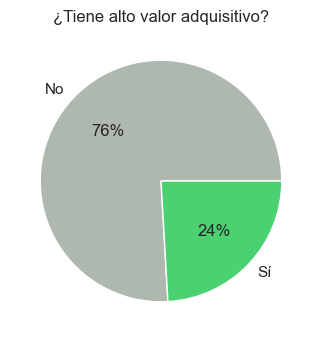

In [34]:
plt.figure(dpi=100)
df["tiene_alto_valor_adquisitivo"].apply(lambda x: 'Sí' if x==1 else 'No').value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['#AEB8AF', '#4AD172']
)
plt.title('¿Tiene alto valor adquisitivo?')
plt.ylabel("")
plt.show()

## Análisis exploratorio

In [35]:
df.columns

Index(['anios_estudiados', 'barrio', 'categoria_de_trabajo', 'edad',
       'estado_marital', 'ganancia_perdida_declarada_bolsa_argentina',
       'genero', 'horas_trabajo_registradas', 'religion',
       'rol_familiar_registrado', 'tiene_alto_valor_adquisitivo', 'trabajo'],
      dtype='object')

### Edad


###### ¿Hay una relación entre la edad y el valor adquisitivo?
Para ello graficaremos la cantidad de gente de cada rango etario para ver las cantidades

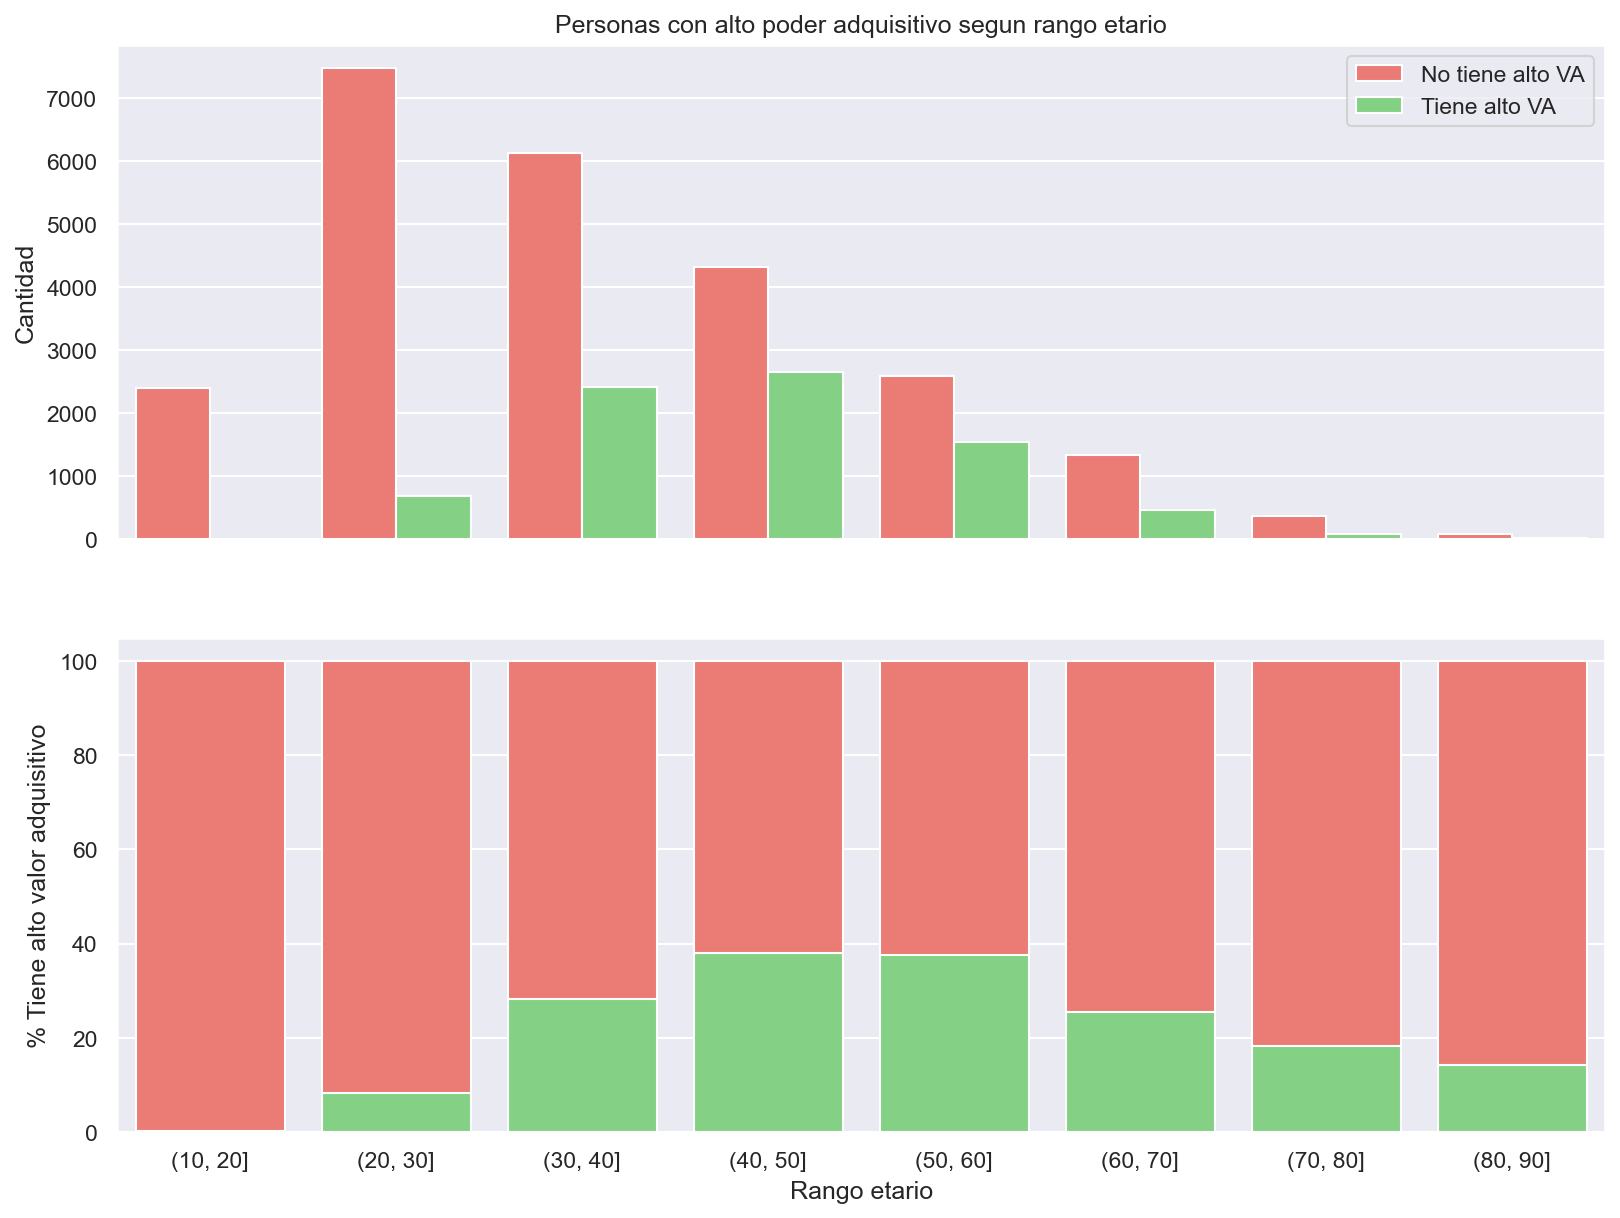

In [102]:
df_tmp = df[['edad', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['rango_etario'] = pd.cut(df_tmp.edad, range(10, int(df_tmp['edad'].max()) + 10, 10))

# Configuro el grafico, armo el countplot y setteo labels varios
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(6.4 * 2, 4.8 * 2))
sns.countplot(
    data = df_tmp,
    x = 'rango_etario',
    hue='tiene_alto_valor_adquisitivo',
    ax = ax1,
    palette = ['#ff6961', '#77dd77']
).set(xticklabels=[])

total = df_tmp.groupby('rango_etario')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1 = df_tmp[df_tmp['tiene_alto_valor_adquisitivo']==1].groupby('rango_etario')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(df_tmp_1['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]
total['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(total['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]

bar1 = sns.barplot(x="rango_etario",  y="tiene_alto_valor_adquisitivo", data=total, color='#ff6961', ax=ax2)
bar2 = sns.barplot(x="rango_etario", y="tiene_alto_valor_adquisitivo", data=df_tmp_1, color='#77dd77', ax=ax2)

top_bar = mpatches.Patch(color='#ff6961')
bottom_bar = mpatches.Patch(color='#77dd77')

ax1.set_title('Personas con alto poder adquisitivo segun rango etario')
ax1.set_xlabel('')
ax1.set_ylabel('Cantidad')
ax1.legend(['No tiene alto VA', 'Tiene alto VA'], loc='upper right')

ax2.set_xlabel('Rango etario')
ax2.set_ylabel('% Tiene alto valor adquisitivo')


plt.show()

## Construyendo el baseline

### Visualizando la ganancia en bolsa

In [30]:
def designar_accion(x):
    if(x > 7000):
        return "Mucha ganancia\n(>7000)"
    elif(x > 0):
        return "Ganancia"
    elif(x == 0):
        return "Nada"
    else:
        return "Perdida"

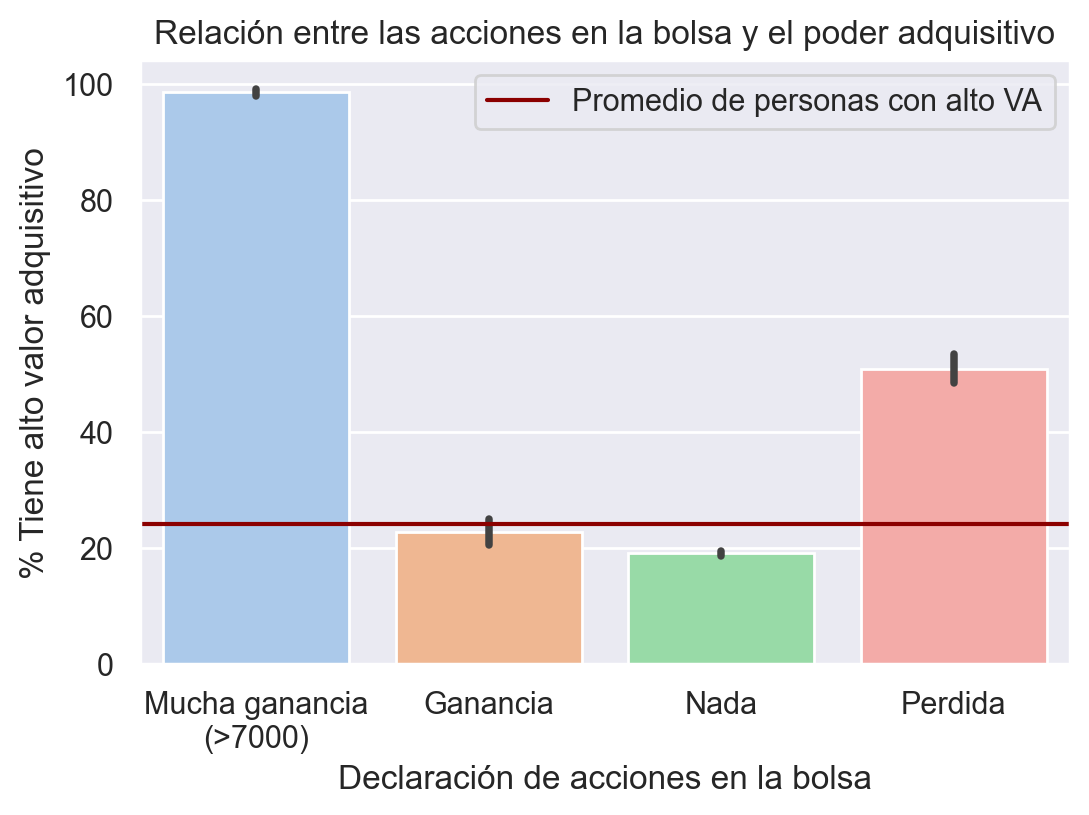

In [31]:
df_tmp = df.copy()
df_tmp['bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'].apply(designar_accion)

plt.figure(dpi=200)
ax = sns.barplot(
    data=df_tmp,
    palette="pastel",
    x='bolsa',
    y='tiene_alto_valor_adquisitivo',
    estimator=lambda x: np.mean(x)*100.0,
    order = ['Mucha ganancia\n(>7000)', 'Ganancia', 'Nada', 'Perdida'],
)
plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Declaración de acciones en la bolsa")
plt.title('Relación entre las acciones en la bolsa y el poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
plt.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
plt.legend()
plt.show()

Por lo que, de aquí sacamos información respecto 

## Observaciones

## Baseline

## Conclusión